In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load dataset
data = pd.read_csv('E:\COLLEGE RESOURCES\semister 6\DEEP LEARNING LAB\DEEP-LEARNING-LAB---AIC3970\WEEK 5\obesity_data.csv')

<>:8: SyntaxWarning: invalid escape sequence '\C'
<>:8: SyntaxWarning: invalid escape sequence '\C'
C:\Users\FAIZ SIDDIQUI\AppData\Local\Temp\ipykernel_6664\1026393252.py:8: SyntaxWarning: invalid escape sequence '\C'
  data = pd.read_csv('E:\COLLEGE RESOURCES\semister 6\DEEP LEARNING LAB\DEEP-LEARNING-LAB---AIC3970\WEEK 5\obesity_data.csv')


In [54]:
data['Gender'].unique()
data.drop('Gender', axis= 1 , inplace= True)

In [55]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder, StandardScaler
encoder = LabelEncoder()
data['ObesityCategory'] = encoder.fit_transform(data['ObesityCategory'])

Training N1 for BMI Regression
Epoch 0, Loss: 6809.3236
Epoch 10, Loss: 38.8870
Epoch 20, Loss: 38.6230
Early stopping at epoch 29


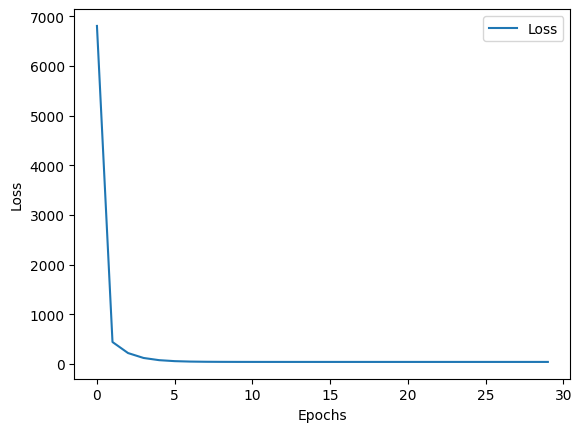

Best loss: 38.6229 at epoch 19
Training N2 for Obesity Classification
Epoch 0, Loss: 1.3421
Epoch 10, Loss: 1.3257
Early stopping at epoch 12


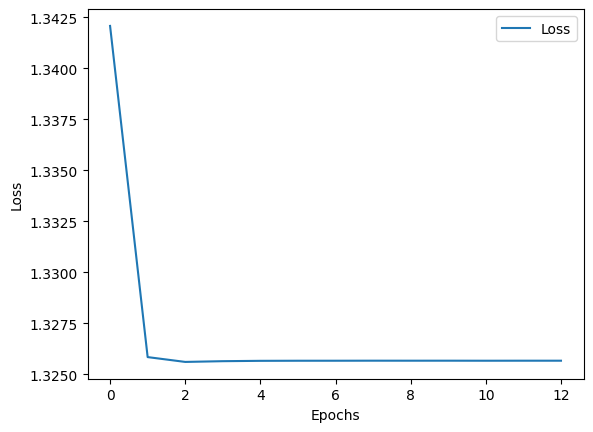

Best loss: 1.3256 at epoch 2


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load dataset
data = pd.read_csv('obesity_data.csv')

# Select features and target variables
X = data[['Age', 'Height', 'Weight', 'BMI', 'PhysicalActivityLevel']].values
y_class = data['ObesityCategory'].values.reshape(-1, 1)  # For classification
y_reg = data['BMI'].values.reshape(-1, 1)  # For regression

# One-hot encoding for classification
ohe = OneHotEncoder(sparse_output=False)
y_class = ohe.fit_transform(y_class)

# Train-test split
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Define Neural Network Layers
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, dropout_rate=0.0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.dropout_rate = dropout_rate
        self.dropout_mask = None

    def forward(self, inputs, training=True):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        if training and self.dropout_rate > 0:
            self.dropout_mask = np.random.rand(*self.output.shape) > self.dropout_rate
            self.output *= self.dropout_mask

    def backward(self, dvalues):
        if self.dropout_rate > 0:
            dvalues *= self.dropout_mask
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# Activation Functions
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    def backward(self, dvalues):
        self.dinputs = self.output * (dvalues - np.sum(dvalues * self.output, axis=1, keepdims=True))

# Loss Functions
class Loss_MSE:
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2)
    def backward(self, y_pred, y_true):
        self.dinputs = -2 * (y_true - y_pred) / y_true.shape[0]

class Loss_CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]
    def backward(self, y_pred, y_true):
        self.dinputs = -y_true / (y_pred + 1e-9)

# Optimizer
class Optimizer_SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    def update_params(self, layer):
        if hasattr(layer, 'weights'):
            layer.weights -= self.learning_rate * layer.dweights
            layer.biases -= self.learning_rate * layer.dbiases

# Training Function
def train_neural_network(X, y, model_structure, loss_function, learning_rate=0.01, epochs=100, batch_size=40, early_stopping=True):
    optimizer = Optimizer_SGD(learning_rate)
    layers = model_structure
    losses = []
    best_loss = float('inf')
    best_epoch = 0

    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Forward pass
            input_data = X_batch
            for layer in layers:
                layer.forward(input_data)
                input_data = layer.output

            loss = loss_function.forward(input_data, y_batch)
            epoch_loss += loss

            # Backward pass
            loss_function.backward(input_data, y_batch)
            gradient = loss_function.dinputs
            for layer in reversed(layers):
                layer.backward(gradient)
                gradient = layer.dinputs

            # Update parameters
            for layer in layers:
                optimizer.update_params(layer)
        
        avg_loss = epoch_loss / (X.shape[0] // batch_size)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
        
        # Early stopping
        if early_stopping and avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch
        elif early_stopping and epoch - best_epoch >= 10:
            print(f"Early stopping at epoch {epoch}")
            break

    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Best loss: {best_loss:.4f} at epoch {best_epoch}")

# Define models
n1_structure = [
    Layer_Dense(5, 64, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(64, 32, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(32, 16, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(16, 1)  # Regression
]

n2_structure = [
    Layer_Dense(5, 64, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(64, 32, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(32, 16, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(16, 8, dropout_rate=0.2), Activation_ReLU(),
    Layer_Dense(8, y_class.shape[1]), Activation_Softmax()  # Classification
]

# Train models
print("Training N1 for BMI Regression")
train_neural_network(X_train, y_train_reg, n1_structure, Loss_MSE())

print("Training N2 for Obesity Classification")
train_neural_network(X_train, y_train_class, n2_structure, Loss_CategoricalCrossentropy())
